# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [ ]:
# !pip install --upgrade scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


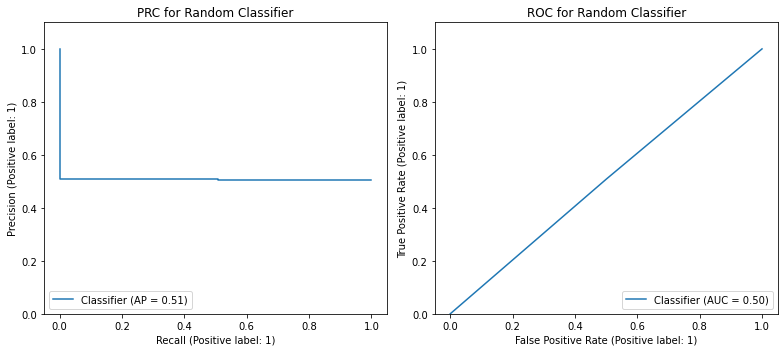

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [ ]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [ ]:
from sklearn.metrics import make_scorer
def my_auc(y_test, y_test_pred):
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    return auc(recall, precision)
auc_pr = make_scorer(my_auc, greater_is_better = True)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

Cs = np.logspace(-2, 3, 5)
searcher = GridSearchCV(LinearSVC(max_iter=100000), [{"C": Cs}], scoring = auc_pr, cv = 10, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)
best_C = searcher.best_params_["C"]
best_C

0.01

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.83254
AUC-ROC: 0.77330


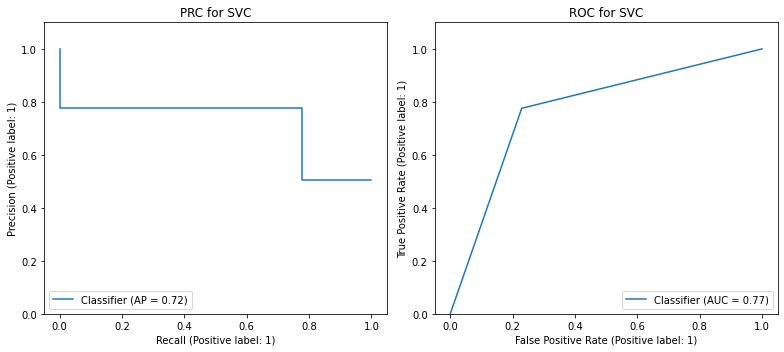

In [ ]:
svc = LinearSVC(max_iter = 100000, C = best_C).fit(X_train_base, y_train_base)
y_test_pred = svc.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_test_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for SVC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_test_pred))
ax[1].set_title("ROC for SVC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [ ]:
df_metrics.loc['SVC'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_test_pred),
    best_C
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVC,0.832540,0.773304,0.01


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Очевидно, для SVC обе метрики стали побольше, т.к. это не рандомайзер, а нормальный классификатор. По кривым также видно, что SVC лучше рандомайзера.

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [ ]:
# в LR по дефолту стоит l_2 регуляризатор
from sklearn.linear_model import LogisticRegression
Cs = np.logspace(-2, 3, 20)
searcher = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": Cs}], scoring = auc_pr, cv = 10, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)
best_C = searcher.best_params_["C"]
best_C

0.01

AUC-PR: 0.83252
AUC-ROC: 0.77330


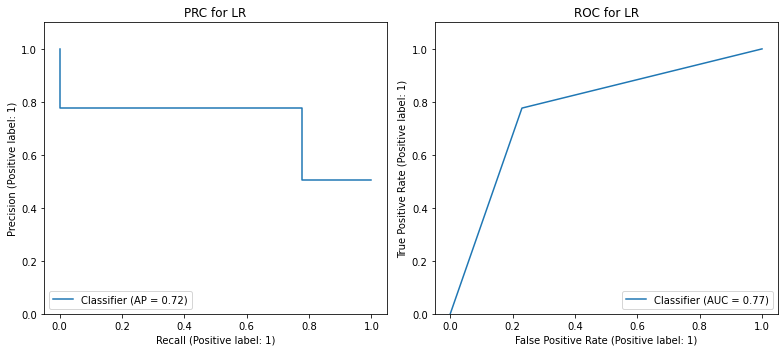

In [ ]:
lr = LogisticRegression(max_iter = 100000, C = best_C).fit(X_train_base, y_train_base)
y_test_pred = lr.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_test_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for LR")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_test_pred))
ax[1].set_title("ROC for LR")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [ ]:
df_metrics.loc['LR'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_test_pred),
    best_C
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVC,0.832540,0.773304,0.01
LR,0.832521,0.773297,0.01


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  **Ответ:**

  Метрики качества получились практически идентичными у SVC и LR. Различий по сути нет. Кривые у них тоже совпадают. Значит, одинаково хорошие методы)))

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [ ]:
from sklearn.svm import SVC

X, y = make_classification(
    n_samples = 10000, n_features = 2, n_informative = 2, n_redundant = 0, random_state = 4242)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

Cs = np.logspace(-2, 3, 20)
searcher = GridSearchCV(SVC(kernel = 'linear', max_iter = 100000), [{"C": Cs}], scoring = auc_pr, cv = 10, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)
best_C = searcher.best_params_["C"]

svc = SVC(kernel = 'linear', max_iter = 100000, C = best_C).fit(X_train_base, y_train_base)
y_test_pred = svc.predict(X_test)

In [ ]:
data = pd.DataFrame(X)
data['class'] = y
data_0 = data.loc[data['class'] == 0]
data_1 = data.loc[data['class'] == 1]

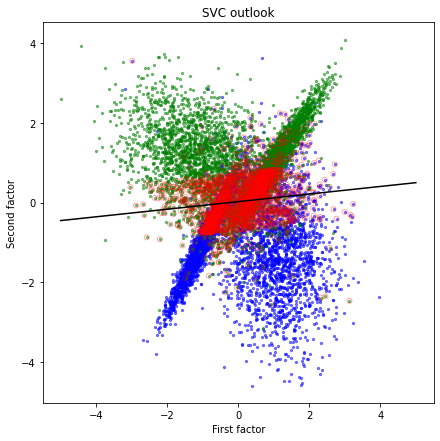

In [ ]:
fig = plt.figure(figsize = (7, 7))

plt.scatter(x = data_0.iloc[:, 0], y = data_0.iloc[:, 1], s = 5, color = 'blue', alpha = 0.5) # все объекты класса 0
plt.scatter(x = data_1.iloc[:, 0], y = data_1.iloc[:, 1], s = 5, color = 'green', alpha = 0.5) # все объекты класса 1
plt.scatter(x = svc.support_vectors_[:, 0], y = svc.support_vectors_[:, 1],
            s = 25, facecolors = 'none', color = 'red', alpha = 0.35) # опорные векторы

w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (svc.intercept_[0]) / w[1]
plt.plot(xx, yy, color = 'black') # гиперплоскость

plt.xlabel('First factor')
plt.ylabel('Second factor')
plt.title('SVC outlook')
plt.show();

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [ ]:
Cs = np.logspace(-2, 3, 20)
searcher = GridSearchCV(LogisticRegression(max_iter = 100000), [{"C": Cs}], scoring = auc_pr, cv = 10, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)
best_C = searcher.best_params_["C"]

lr = LogisticRegression(max_iter = 100000, C = best_C).fit(X_train_base, y_train_base)
y_test_pred = lr.predict(X_test)

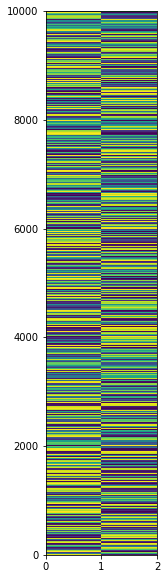

In [ ]:
fig = plt.figure(figsize = (2, 10))
plt.pcolor(lr.predict_proba(X)); # ну, раз вы сами попросили pcolor... как смоглось, иначе фигня какая-то

Здесь для каждого из 10000 объектов указана вероятность в левом градиенте - оказаться объектом 0-ого класса, в правом градиенте - объектом 1-ого класса. Выглядит приплюснуто, но что поделать, зато информативно.

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds, color = 'red'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # исправлено
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / len(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], linestyle = '--', color = 'green')
    plt.plot(bin_middle_points, bin_real_ratios, color = color)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [ ]:
X, y = make_classification(
    n_samples = 10000, n_features = 10, n_informative = 5, n_redundant = 5, random_state = 4242)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4242)

X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 4242)

In [ ]:
Cs_svc = np.logspace(-2, 3, 20)
searcher = GridSearchCV(SVC(kernel = 'linear', max_iter = 100000), [{"C": Cs_svc}], scoring = auc_pr, cv = 10, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)
best_C_svc = searcher.best_params_["C"]

svc = SVC(kernel = 'linear', max_iter = 100000, C = best_C_svc).fit(X_train_base, y_train_base)
pred_svc = svc.decision_function(X_test)
y_test_pred_svc = (pred_svc - pred_svc.min()) / (pred_svc.max() - pred_svc.min()) # нормируем предикты

Cs_lr = np.logspace(-2, 3, 20)
searcher = GridSearchCV(LogisticRegression(max_iter = 100000), [{"C": Cs_lr}], scoring = auc_pr, cv = 10, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)
best_C_lr = searcher.best_params_["C"]

lr = LogisticRegression(max_iter = 100000, C = best_C_lr).fit(X_train_base, y_train_base)
y_test_pred_lr = lr.predict_proba(X_test)[:, 1] # выбираем только вероятность принадлежности классу 1

<Figure size 360x360 with 0 Axes>

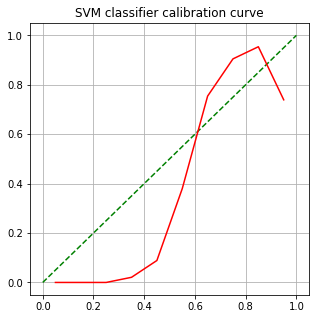

In [ ]:
fig = plt.figure(figsize=(5, 5))
plot_calibration_curve(y_test, y_test_pred_svc, 'red')
plt.title('SVM classifier calibration curve');

<Figure size 360x360 with 0 Axes>

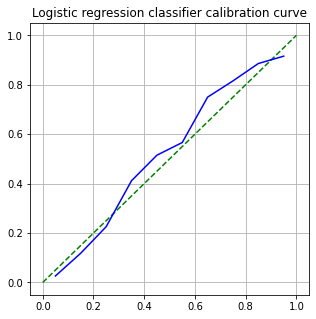

In [ ]:
fig = plt.figure(figsize=(5, 5))
plot_calibration_curve(y_test, y_test_pred_lr, 'blue')
plt.title('Logistic regression classifier calibration curve');

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

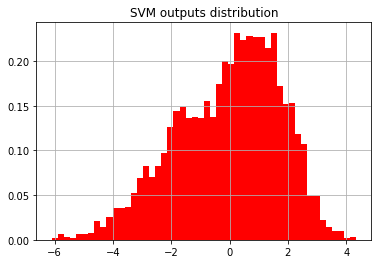

In [ ]:
plt.hist(svc.decision_function(X_test), bins = 50, color = 'red', density = 'True')
plt.title('SVM outputs distribution')
plt.grid();

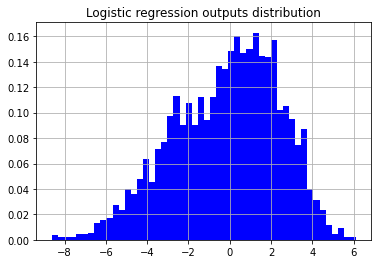

In [ ]:
plt.hist(lr.decision_function(X_test), bins = 50, color = 'blue', density = 'True')
plt.title('Logistic regression outputs distribution')
plt.grid();


Чем они различаются? Чем вы можете объяснить это?

**Ответ:**

Ну практически ничем не отличаются. Это вроде бы логично. Раз распределения ответов схожи, то оба классификатора хорошо предсказывают класс. Они же оба и стремятся к тому, чтобы распределение их ответов максимально было близко к истинному. Так что всё круто.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

Cs_svc = np.logspace(-2, 3, 20)
svc_calibrated = CalibratedClassifierCV(base_estimator = SVC(kernel = 'linear', max_iter = 100000), cv = 3)
searcher = GridSearchCV(svc_calibrated, [{"base_estimator__C": Cs_svc}], scoring = auc_pr, cv = 10, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)
best_C_svc = searcher.best_params_["base_estimator__C"]

svc_calibrated = CalibratedClassifierCV(base_estimator = SVC(kernel = 'linear', 
                                                             max_iter = 100000,
                                                             C = best_C_svc), cv = 3).fit(X_train_base, y_train_base)
y_test_pred_svc_calibrated = svc_calibrated.predict_proba(X_test)[:, 1]

<Figure size 360x360 with 0 Axes>

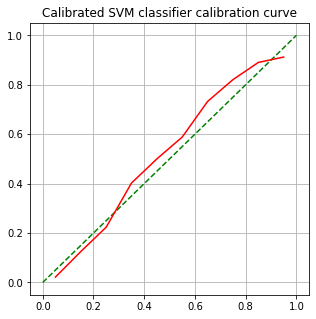

In [ ]:
fig = plt.figure(figsize=(5, 5))
plot_calibration_curve(y_test, y_test_pred_svc_calibrated, 'red')
plt.title('Calibrated SVM classifier calibration curve');

Да, калибровочная кривая стала лучше. Т.к. по умолчанию в `CalibratedClassifierCV` используется логистическая регрессия (сигмоидная калибровка), то стоило ожидать лучшую вероятностную сущность выходов нашего классификатора по сравнению с ним же до калибровки. Так и вышло.

---



##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-17 10:41:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  7.37MB/s    in 0.5s    

2022-11-17 10:41:38 (7.37 MB/s) - ‘adult.data’ saved [3974305/3974305]



In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [ ]:

df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['income']),
                                                    df['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = df['income'])

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

column_transformer = ColumnTransformer([
    ('orde', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

def oblegchator(X_train, X_test, y_train, y_test, column_transformer): # запишу сразу на все случаи жизни
    pipeline = Pipeline([
        ('column_trans', column_transformer),
        ('classifier', LogisticRegression(max_iter = 100000))
    ])
    
    X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 777)
    
    Cs_log = np.logspace(-2, 3, 20)
    searcher = GridSearchCV(pipeline, [{"classifier__C": Cs_log}], scoring = auc_pr, cv = 10, n_jobs = -1)
    searcher.fit(X_train_val, y_train_val)
    
    best_C_log = searcher.best_params_["classifier__C"]
    
    pipeline = Pipeline([
        ('column_trans', column_transformer),
        ('classifier', LogisticRegression(max_iter = 100000, C = best_C_log))
    ])
    
    start_time = time.time()
    lr_new = pipeline.fit(X_train_base, y_train_base)
    time_score = time.time() - start_time # замеренное время
    
    precision, recall, _ = precision_recall_curve(y_test, lr_new.predict(X_test))
    print('AUC-PR: %.5f' % auc(recall, precision))
    print('Training time: %f' % time_score)
    return lr_new

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  category=UserWarning,


AUC-PR: 0.63657
Training time: 0.895599


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('orde', OrdinalEncoder(),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('classifier', LogisticRegression(C=0.01, max_iter=100000))])

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__:

Предположу, что наш класс `income` = 1 - имба (imbalanced), т.е. у нас очень мало объектов класса 1 и много объектов класса 0. Т.е. много бедных (< $50K / год). Тогда нам интереснее использовать именно AUC-PR, т.к. именно эта метрика позволяет учесть важность и того, чтобы мы не называли бедных богачами (чтобы было мало FP), и того, чтобы мы не называли богачей бедными (чтобы было мало FN). Тогда резонно использовать именно AUC-PR, а не другие метрики.

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  category=UserWarning,


AUC-PR: 0.70986
Training time: 0.183799


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('classifier', LogisticRegression(C=0.01, max_iter=100000))])

Во-первых, "до кодирования" модели не было и быть не могло. Полагаю имелось в виду сравнить модель с той, что была при `OrdinalEncoder`. Тогда есть очевидный результат - увеличение AUC-PR. наша модель стала лучше, т.к. теперь мы не создаём дополнительных предпосылок для данных. И мало того, время на всё про всё уменьшилось! Вот это неожиданно... Ну ладно, вроде логике вещей не противоречит.

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
# Заметим, что тут про векторизованные вычисления ничего не сказано)))
def mean_target_vanilla(df, column):
    C = df.copy()
    A = C.groupby(by = column).mean()[['income']]
    B = C.merge(A, how = 'left', on = [column])
    C[column] = B['income_y']
    return C

In [ ]:
data = df.copy()
for i in categorical: # совершаю преступление
    data = mean_target_vanilla(data, i)
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0.271957,77516,0.414753,13,0.045961,0.134483,0.103070,0.25586,0.305737,2174,0,40,0.245835,0
1,50,0.284927,83311,0.414753,13,0.446848,0.484014,0.448571,0.25586,0.305737,0,0,13,0.245835,0
2,38,0.218673,215646,0.159509,9,0.104209,0.062774,0.103070,0.25586,0.305737,0,0,40,0.245835,0
3,53,0.218673,234721,0.051064,7,0.446848,0.062774,0.448571,0.12388,0.305737,0,0,40,0.245835,0
4,28,0.218673,338409,0.414753,13,0.446848,0.449034,0.475128,0.12388,0.109461,0,0,40,0.263158,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['income']),
                                                    data['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data['income'])

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric + categorical)
])

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

AUC-PR: 0.70895
Training time: 0.120415


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=2.3357214690901213, max_iter=100000))])

Качество на тестовой выборке по сути такое же, как у `OneHotEncoder`, а вот время примерно (зависит от случая) в два раза меньше. Т.е. имея такое же качество, имеем наименьшее время его достижения. По всем фронтам победа. И считаем всё это дело быстрее, и получается так же хорошо. Сплошные плюсы.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [ ]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [ ]:
def mean_target_noise(df, column, scaler = 1.0, seed = 42):
    C = df.copy()
    A = C.groupby(by = column).mean()[['income']]
    B = C.merge(A, how = 'left', on = [column])
    np.random.seed(seed)
    C[column] = pd.DataFrame(B['income_y'] + scaler * B['income_y'] * np.random.normal(loc = 0, scale = 0.25, size = B['income_y'].shape[0]))
    return C

Я переписал функцию для `mean_target`, добавив новый параметр - `scaler`. Это параметр нашего предпочтения непереобученности. Т.е. чем он больше, тем более мы предпочитаем может быть и менее полезные, но зато и менее переобученные признаки. Как он работает: я создаю нормальный шум, к минтаргет-кодированным признакам я добавляю не сам этот шум, а этот шум помноженный на сами признаки. Проще говоря, я по сути шумом создаю доли, на которые случайно скорректирую свои закодированные признаки. Т.е. добавляю/отнимаю от признака не чисто рандомную величину, а такую-то его собственную долю и т.п. Это действует как некоторое шкалирование. Я учитываю значение признака при его зашумлении. Так, у меня меньше вероятность громко зашумить маленький признак или наоборот. Тут всё пропорционально. А `scaler` мне нужен для того, чтобы регулировать то, насколько громко я шумлю по всем признакам. Чем он больше, тем громче шум на всех категориях. Тогда получается, что наша модель будет по таким признакам меньше переобучаться, но сами они чутка бесполезнее, чем могли бы быть. И наоборот. Чем меньше `scaler`, тем больше мы ценим полезность признаков и тем больше готовы ради неё переобучиться. Вот вам и баланс. С одной стороны - все признаки зашумляются пропорционально себе, с другой - общую громкость можете регулировать сами))))

In [ ]:
data = df.copy()
for i in categorical: # совершаю преступление
    data = mean_target_noise(data, i, 0.5)
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0.288842,77516,0.440504,13,0.048815,0.142833,0.109470,0.271746,0.324720,2174,0,40,0.261098,0
1,50,0.280003,83311,0.407584,13,0.439125,0.475649,0.440819,0.251438,0.300453,0,0,13,0.241586,0
2,38,0.236377,215646,0.172423,9,0.112646,0.067856,0.111415,0.276575,0.330489,0,0,40,0.265738,0
3,53,0.260304,234721,0.060785,7,0.531919,0.074725,0.533970,0.147464,0.363942,0,0,40,0.292636,0
4,28,0.212273,338409,0.402613,13,0.433769,0.435891,0.461221,0.120254,0.106257,0,0,40,0.255455,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['income']),
                                                    data['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data['income'])

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric + categorical)
])

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

AUC-PR: 0.70280
Training time: 0.119498


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=26.366508987303583, max_iter=100000))])

Короче, качество и скорость сильно не изменились с моим заданным `scaler` = 0.5, они примерно такие же, как и в модели без шума. Это нормально. Если выбрать `scaler` побольше, то качество и скорость начнут падать. Это наверняка объясняется неким trade-off между переобученностью и полезностью, но в любом случае этот гиперпараметр нужно подбирать, ибо вот так вот тыкнуть в небо не могу, какой был бы наилучшим. Но при этом по сетке его сейчас искать не буду, ибо зачем, мы же тут за идеей, а не за цифрами. Идейно, шум работает. Его можно регулировать. Качество и скорость от этого меняются. Вот главный вывод.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способом из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [ ]:
def mean_target_smooth(df, column, scaler = 1.0):
    C = df.copy()
    G = C.groupby(by = column).mean()['income']
    H = C[column].value_counts()
    V = pd.DataFrame()
    V['mean'] = pd.DataFrame((G * H + scaler * C['income'].mean()) / (H + scaler)) # умножаю G на H чтобы получить сумму из числителя
    V = V.reset_index().rename(columns = {'index': column})
    F = C.merge(V, how = 'left', on = [column])
    C[column] = pd.DataFrame(F['mean'])
    return C

In [ ]:
data = df.copy()
for i in categorical: # совершаю преступление
    data = mean_target_smooth(data, i, 10)
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0.271719,77516,0.414428,13,0.046143,0.134764,0.103236,0.255855,0.305707,2174,0,40,0.245833,0
1,50,0.284754,83311,0.414428,13,0.446711,0.483417,0.448414,0.255855,0.305707,0,0,13,0.245833,0
2,38,0.218683,215646,0.159586,9,0.104516,0.064064,0.103236,0.255855,0.305707,0,0,40,0.245833,0
3,53,0.218683,234721,0.052665,7,0.446711,0.064064,0.448414,0.124253,0.305707,0,0,40,0.245833,0
4,28,0.218683,338409,0.414428,13,0.446711,0.448532,0.473643,0.124253,0.109582,0,0,40,0.261029,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['income']),
                                                    data['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data['income'])

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric + categorical)
])

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

AUC-PR: 0.70806
Training time: 0.126318


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=0.6951927961775606, max_iter=100000))])

Как видно, опять-таки, результат сильно не изменился. Ну и ладно, зато маленькие категории будут усредняться по нашему коду.

#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [ ]:
a = pd.DataFrame(df['age'].value_counts())
a.loc[a['age'] < 100] # значения возраста, которые встречаются реже 100 раз в выборке

,age
70,89
71,72
72,67
73,64
74,51
76,46
75,45
90,43
77,29
78,23


In [ ]:
a = pd.DataFrame(df['hours-per-week'].value_counts())
a.loc[a['hours-per-week'] < 20] # значения рабочих часов, которые встречаются реже 20 раз в выборке

,hours-per-week
62,18
9,18
57,17
66,17
19,14
64,14
51,13
85,13
68,12
98,11


In [ ]:
data = df.copy() # сначала за мин-таргетим все остальные признаки
for i in categorical: # совершаю преступление
    data = mean_target_noise(data, i, 0.5)
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0.288842,77516,0.440504,13,0.048815,0.142833,0.109470,0.271746,0.324720,2174,0,40,0.261098,0
1,50,0.280003,83311,0.407584,13,0.439125,0.475649,0.440819,0.251438,0.300453,0,0,13,0.241586,0
2,38,0.236377,215646,0.172423,9,0.112646,0.067856,0.111415,0.276575,0.330489,0,0,40,0.265738,0
3,53,0.260304,234721,0.060785,7,0.531919,0.074725,0.533970,0.147464,0.363942,0,0,40,0.292636,0
4,28,0.212273,338409,0.402613,13,0.433769,0.435891,0.461221,0.120254,0.106257,0,0,40,0.255455,0


In [ ]:
# теперь переберём мин-таргетинг вот этих двух (использую шум)
data_age = mean_target_noise(data, 'age', 0.5)
data_age.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.361839,0.288842,77516,0.440504,13,0.048815,0.142833,0.109470,0.271746,0.324720,2174,0,40,0.261098,0
1,0.426062,0.280003,83311,0.407584,13,0.439125,0.475649,0.440819,0.251438,0.300453,0,0,13,0.241586,0
2,0.368599,0.236377,215646,0.172423,9,0.112646,0.067856,0.111415,0.276575,0.330489,0,0,40,0.265738,0
3,0.484874,0.260304,234721,0.060785,7,0.531919,0.074725,0.533970,0.147464,0.363942,0,0,40,0.292636,0
4,0.133238,0.212273,338409,0.402613,13,0.433769,0.435891,0.461221,0.120254,0.106257,0,0,40,0.255455,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_age.drop(columns = ['income']),
                                                    data_age['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data_age['income'])

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric + categorical)
])

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

AUC-PR: 0.70436
Training time: 0.141738


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=48.32930238571752, max_iter=100000))])

Закодировав `age`, я получил результаты не прям лучше чем были (качество почти такое же), но по сравнению с обычным зашумлением классификатор работает быстрее (иногда).

In [ ]:
data_hours = mean_target_noise(data, 'hours-per-week', 0.25) # заметим, что я снизил scaler!
data_hours.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0.288842,77516,0.440504,13,0.048815,0.142833,0.109470,0.271746,0.324720,2174,0,0.220004,0.261098,0
1,50,0.280003,83311,0.407584,13,0.439125,0.475649,0.440819,0.251438,0.300453,0,0,0.086205,0.241586,0
2,38,0.236377,215646,0.172423,9,0.112646,0.067856,0.111415,0.276575,0.330489,0,0,0.222017,0.265738,0
3,53,0.260304,234721,0.060785,7,0.531919,0.074725,0.533970,0.147464,0.363942,0,0,0.233691,0.292636,0
4,28,0.212273,338409,0.402613,13,0.433769,0.435891,0.461221,0.120254,0.106257,0,0,0.210257,0.255455,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_hours.drop(columns = ['income']),
                                                    data_hours['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data_hours['income'])

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric + categorical)
])

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

AUC-PR: 0.70042
Training time: 0.106736


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=14.38449888287663, max_iter=100000))])

Качество от зашумления часов у меня чутка падало, а время порою подрастало, когда я использовал `scaler` = 0.5... Наверное, не стоит так делать, подумал я. И решил выбрать `scaler` поменьше. Со значением 0.25 кодирование `hours-per-week` выглдяит гораздо лучше. Качество падает слабее, а скорость почти такая же, даже чутка ниже.

In [ ]:
data_both = mean_target_noise(data, 'age', 0.5)
data_both = mean_target_noise(data_both, 'hours-per-week', 0.25)
data_both.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.361839,0.288842,77516,0.440504,13,0.048815,0.142833,0.109470,0.271746,0.324720,2174,0,0.220004,0.261098,0
1,0.426062,0.280003,83311,0.407584,13,0.439125,0.475649,0.440819,0.251438,0.300453,0,0,0.086205,0.241586,0
2,0.368599,0.236377,215646,0.172423,9,0.112646,0.067856,0.111415,0.276575,0.330489,0,0,0.222017,0.265738,0
3,0.484874,0.260304,234721,0.060785,7,0.531919,0.074725,0.533970,0.147464,0.363942,0,0,0.233691,0.292636,0
4,0.133238,0.212273,338409,0.402613,13,0.433769,0.435891,0.461221,0.120254,0.106257,0,0,0.210257,0.255455,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_both.drop(columns = ['income']),
                                                    data_both['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data_both['income'])

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric + categorical)
])

oblegchator(X_train, X_test, y_train, y_test, column_transformer)

AUC-PR: 0.70874
Training time: 0.119306


Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=1.2742749857031335, max_iter=100000))])

Совместная тема тоже ничего сильно не поменяла. Ну ладно.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

Во-первых, они работают быстрее. Я не знаю должны ли счётчики выдавать большее качество, чем OneHot (у меня такого не было), но вот очевидное ускорение классификации у меня точно наблюдалось. Качество, как я сказал, у меня и там, и там ну примерно одинаковое. Замечу, что счётчики требуют меньше памяти. Это круто. Создавать датафрейм со сплошными нулями при OneHot-кодировании это ну... такое. Лишнее пространство тратить. Плюс, счётчики позволяют зашумлять данные в явном виде, чтобы избежать утечки таргета. И вот тут перейду к минусу - счётчики в принципе позволяют утечку таргета. Да, с этим можно бороться, но идейно это уже есть, с этим нужно жить. Думаю, всё расписал, что считаю.

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['income']),
                                                    df['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), categorical)
])
data = column_transformer.fit_transform(X_train)
print('Factors pre-OneHot: %i' % df.shape[1])
print('Factors after OneHot: %i' % data.shape[1])

Factors pre-OneHot: 15
Factors after OneHot: 102


Сильно так почти в 10 раз признаков приросло.

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
def pomogator(data_vector): # запишу сразу на все случаи жизни
    pipeline = Pipeline([
        ('classifier', LogisticRegression(max_iter = 100000))
    ])
    X_train = data_vector[0]
    X_test = data_vector[1]
    y_train = data_vector[2]
    y_test = data_vector[3]
    
    X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 777)
    
    Cs_log = np.logspace(-2, 3, 20)
    searcher = GridSearchCV(pipeline, [{"classifier__C": Cs_log}], scoring = auc_pr, cv = 10, n_jobs = -1)
    searcher.fit(X_train_val, y_train_val)
    
    best_C_log = searcher.best_params_["classifier__C"]
    
    pipeline = Pipeline([
        ('classifier', LogisticRegression(max_iter = 100000, C = best_C_log))
    ])
    
    start_time = time.time()
    lr_new = pipeline.fit(X_train_base, y_train_base)
    time_score = time.time() - start_time # замеренное время
    
    precision, recall, _ = precision_recall_curve(y_test, lr_new.predict(X_test))
    return [lr_new, auc(recall, precision), time_score]

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])
data = pd.DataFrame(column_transformer.fit_transform(df.drop(columns = ['income'])))
data['income'] = df['income']
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['income']),
                                                    data['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data['income'])

Я решил весь трансформинг сделать до обучения, в помогаторе только чистое обучение и фиттинг записаны.

In [ ]:
pomogator_base = pomogator([X_train, X_test, y_train, y_test])
pomogator_base

[Pipeline(steps=[('classifier',
                  LogisticRegression(C=0.20691380811147891, max_iter=100000))]),
 0.7229668871405397,
 0.8486759662628174]

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модель заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
from heapq import nlargest
def fortyfier(pomogator_thing, data):
    pre_40 = time.time() # START
    coef = pd.DataFrame(abs(pomogator_thing[0][0].coef_).T).reset_index()
    s = pd.DataFrame(nlargest(40, coef[0]))
    s['is_big'] = 1
    coef = coef.merge(s, how = 'left', on = [0])
    index = np.array(coef.loc[coef['is_big'] != 1]['index'])
    data_40 = data.drop(columns = index)
    X_train, X_test, y_train, y_test = train_test_split(data_40.drop(columns = ['income']),
                                                        data_40['income'],
                                                        test_size = 0.25,
                                                        random_state = 777,
                                                        stratify = data_40['income'])
    time_40 = time.time() - pre_40 # FINISH
    return [[X_train, X_test, y_train, y_test], time_40]
forty = fortyfier(pomogator_base, data)
print('Time to pick 40 best: %f' % forty[1])

Time to pick 40 best: 0.043731


In [ ]:
pomogator_40 = pomogator(forty[0])
pomogator_40

[Pipeline(steps=[('classifier',
                  LogisticRegression(C=1.2742749857031335, max_iter=100000))]),
 0.716491391360394,
 0.7650880813598633]

Изменилось ли качество? Как?

Неа. Качество такое же. Ну почти идентичное. Только считает быстрее.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
column_transformer_unscaled = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), categorical)
])
data_unscaled = pd.DataFrame(column_transformer_unscaled.fit_transform(df.drop(columns = ['income'])))
data_unscaled['income'] = df['income']
X_train, X_test, y_train, y_test = train_test_split(data_unscaled.drop(columns = ['income']),
                                                    data_unscaled['income'],
                                                    test_size = 0.25,
                                                    random_state = 777,
                                                    stratify = data_unscaled['income'])
pomogator_unscaled = pomogator([X_train, X_test, y_train, y_test])
pomogator_unscaled

[Pipeline(steps=[('classifier',
                  LogisticRegression(C=0.37926901907322497, max_iter=100000))]),
 0.6742680182739405,
 0.8885085582733154]

In [ ]:
forty_unscaled = fortyfier(pomogator_unscaled, data_unscaled)
print('Time to pick 40 best: %f' % forty_unscaled[1])

Time to pick 40 best: 0.053391


In [ ]:
pomogator_40_unscaled = pomogator(forty_unscaled[0])
pomogator_40_unscaled

[Pipeline(steps=[('classifier',
                  LogisticRegression(C=2.3357214690901213, max_iter=100000))]),
 0.6667136522412531,
 0.7517807483673096]

Да то же самое только в профиль. Сами нешкалированные данные и так были хуже шкалированных, а лучшие 40 даже чуууууть-чуть принизили качество. Причём соотношение между общим методом и методом сорока такое же, как и у шкалированных методов - у метода сорока ну примерно такое же качество и чутка повыше скорость в сравнении с общим методом. По сути больше-то ничего и не скажешь.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
def fool(me):
    print('you will not fool %s' % me)
me = 'me'

In [ ]:
fool(me)

you will not fool me


OneHot-кодированные признаки и так будут в шкале от 0 до 1. Абсолютно ничего не поменяется, если их отшкалировать на отрезок от 0 до 1.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
from math import sqrt
def t_stat(data):
    pre_40 = time.time() # START

    t_vector = []
    for column in data.columns.drop('income'):
        mu_plus = data.loc[data['income'] == 1][column].mean()
        mu_minus = data.loc[data['income'] != 1][column].mean()
        n_plus = data.loc[data['income'] == 1][column].shape[0]
        n_minus = data.loc[data['income'] != 1][column].shape[0]
        sigma_plus = data.loc[data['income'] == 1][column].std()
        sigma_minus = data.loc[data['income'] != 1][column].std()
        t = abs(mu_plus - mu_minus) / sqrt((n_plus*sigma_plus + n_minus*sigma_minus) / (n_plus + n_minus))
        t_vector.append(t)

    t_vector = pd.DataFrame(t_vector).reset_index()
    s = pd.DataFrame(nlargest(40, t_vector[0]))
    s['is_big'] = 1
    t_vector = t_vector.merge(s, how = 'left', on = [0])
    index = np.array(t_vector.loc[t_vector['is_big'] != 1]['index'])
    data_40 = data.drop(columns = index)
    X_train, X_test, y_train, y_test = train_test_split(data_40.drop(columns = ['income']),
                                                        data_40['income'],
                                                        test_size = 0.25,
                                                        random_state = 777,
                                                        stratify = data_40['income'])
    time_40 = time.time() - pre_40 # FINISH
    return [[X_train, X_test, y_train, y_test], time_40]
t_statistic = t_stat(data)
print('Time to pick 40 best: %f' % t_statistic[1])

Time to pick 40 best: 3.578018


In [ ]:
pomogator_40_t = pomogator(t_statistic[0])
pomogator_40_t

[Pipeline(steps=[('classifier',
                  LogisticRegression(C=0.37926901907322497, max_iter=100000))]),
 0.707135353904564,
 0.5017499923706055]

Качество не поменялось особо, время выполнения в два раза сократилось!

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
data = pd.DataFrame(column_transformer.fit_transform(df.drop(columns = ['income'])))
data['income'] = df['income']

Сделаю двойной критерий остановки. Т.к. наша модель может достигнуть максимума и на 70 признаках, и на 60 и т.д. Пусть наша штука будет работать, пока либо не останется 40 признаков, либо качество не окажется ниже, чем на последних трёх прокрутках модели.

In [ ]:
def torture(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['income']),
                                                        data['income'],
                                                        test_size = 0.25,
                                                        random_state = 777,
                                                        stratify = data['income'])
    max_qulaity_1 = 0
    max_qulaity_2 = 0
    max_qulaity_3 = 0
    stop = False
    while stop == False:
        quality = []
        for i in X_train.columns:
            data_i = X_train.drop(columns = [i])
            X_tr, X_ts, y_tr, y_ts = train_test_split(data_i,
                                                      y_train,
                                                      test_size = 0.90,
                                                      random_state = 777,
                                                      stratify = y_train)
            pipeline = Pipeline([
                ('classifier', LogisticRegression(max_iter = 100000, C = 0.01))
            ])

            lr = pipeline.fit(X_tr, y_tr)
            precision, recall, _ = precision_recall_curve(y_ts, lr.predict(X_ts))
            q = auc(recall, precision)
            quality.append(q)
        quality = pd.DataFrame(quality).reset_index()
        worse_1 = (quality[0].max() < max_qulaity_1)
        worse_2 = (quality[0].max() < max_qulaity_2)
        worse_3 = (quality[0].max() < max_qulaity_3)
        worse = worse_1 & worse_2 & worse_3
        if worse == True:
            stop = True
        if worse == False:
            max_qulaity_3 = max_qulaity_2
            max_qulaity_2 = max_qulaity_1
            max_qulaity_1 = quality[0].max()
            drop_candidate = int(quality.loc[quality[0] == quality[0].max()][['index']].iloc[0, 0])
            X_train = X_train.drop(columns = [drop_candidate])
            X_test = X_test.drop(columns = [drop_candidate])
            if X_train.shape[1] <= 40:
                stop = True
            if X_train.shape[1] > 40:
                pass
        
    X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(X_train,
                                                                            y_train,
                                                                            test_size = 0.10,
                                                                            random_state = 777,
                                                                            stratify = y_train)
    pipeline = Pipeline([
        ('classifier', LogisticRegression(max_iter = 100000))
    ])
    Cs = np.logspace(-2, 3, 5)
    searcher = GridSearchCV(pipeline, [{"classifier__C": Cs}], scoring = auc_pr, cv = 10, n_jobs = -1)
    searcher.fit(X_train_val, y_train_val)

    best_C = searcher.best_params_["classifier__C"]

    pipeline = Pipeline([
        ('classifier', LogisticRegression(max_iter = 100000, C = best_C))
    ])

    start_time = time.time()
    lr = pipeline.fit(X_train_base, y_train_base)
    time_score = time.time() - start_time # замеренное время
    
    precision, recall, _ = precision_recall_curve(y_test, lr.predict(X_test))
    return [lr, auc(recall, precision), time_score]

crash = torture(data)
crash

[Pipeline(steps=[('classifier',
                  LogisticRegression(C=3.1622776601683795, max_iter=100000))]),
 0.7113527883924684,
 3.2306482791900635]

Неплохое качество.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Хз, найдётся ли, но механику с тремя худшими результатами я оставил, так что за это беспокоится не стоит.

In [123]:
def suffering(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['income']),
                                                        data['income'],
                                                        test_size = 0.25,
                                                        random_state = 777,
                                                        stratify = data['income'])
    max_qulaity_1 = 0
    max_qulaity_2 = 0
    max_qulaity_3 = 0
    stop = False
    data_i = pd.DataFrame(np.zeros(X_train.shape[0]))
    test_i = pd.DataFrame(np.zeros(X_test.shape[0]))
    used = []
    while stop == False:
        quality = []
        for i in X_train.columns.drop(used):
            dummy_i = pd.DataFrame(X_train[i])
            if data_i.iloc[:, 0].sum() != 0:
                dummy_i = dummy_i.join(data_i)
            else:
                pass
            # display(dummy_i) # можете включить вот этот дисплей, чтобы увидеть, что набор колоночек работает хорошо
            X_tr, X_ts, y_tr, y_ts = train_test_split(dummy_i,
                                                      y_train,
                                                      test_size = 0.90,
                                                      random_state = 777)
            pipeline = Pipeline([
                ('classifier', LogisticRegression(max_iter = 100000, C = 0.01))
            ])

            lr = pipeline.fit(X_tr, y_tr)
            precision, recall, _ = precision_recall_curve(y_ts, lr.predict(X_ts))
            q = auc(recall, precision)
            quality.append(q)
        quality = pd.DataFrame(quality).reset_index()
        worse_1 = (quality[0].max() < max_qulaity_1)
        worse_2 = (quality[0].max() < max_qulaity_2)
        worse_3 = (quality[0].max() < max_qulaity_3)
        worse = worse_1 & worse_2 & worse_3
        if worse == True:
            stop = True
        if worse == False:
            max_qulaity_3 = max_qulaity_2
            max_qulaity_2 = max_qulaity_1
            max_qulaity_1 = quality[0].max()
            candidate = int(quality.loc[quality[0] == quality[0].max()][['index']].iloc[0, 0])
            if data_i.iloc[:, 0].sum() == 0:
                data_i = pd.DataFrame(X_train[candidate])
            else:
                data_i[candidate] = pd.DataFrame(X_train[candidate])
            data_i = data_i.fillna(method = 'ffill')
            used.append(candidate)
            if test_i.iloc[:, 0].sum() == 0:
                test_i = pd.DataFrame(X_test[candidate])
            else:
                test_i[candidate] = pd.DataFrame(X_test[candidate])
            if data_i.shape[1] > 40:
                stop = True
            if data_i.shape[1] <= 40:
                pass
        
    X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(data_i,
                                                                            y_train,
                                                                            test_size = 0.10,
                                                                            random_state = 777,
                                                                            stratify = y_train)
    pipeline = Pipeline([
        ('classifier', LogisticRegression(max_iter = 100000))
    ])
    Cs = np.logspace(-2, 3, 5)
    searcher = GridSearchCV(pipeline, [{"classifier__C": Cs}], scoring = auc_pr, cv = 10, n_jobs = -1)
    searcher.fit(X_train_val, y_train_val)

    best_C = searcher.best_params_["classifier__C"]

    pipeline = Pipeline([
        ('classifier', LogisticRegression(max_iter = 100000, C = best_C))
    ])

    start_time = time.time()
    lr = pipeline.fit(X_train_base, y_train_base)
    time_score = time.time() - start_time # замеренное время
    
    precision, recall, _ = precision_recall_curve(y_test, lr.predict(test_i))
    return [lr, auc(recall, precision), time_score]

blue_screen_of_death = suffering(data)
blue_screen_of_death

[Pipeline(steps=[('classifier', LogisticRegression(C=0.01, max_iter=100000))]),
 0.6419818695298589,
 0.07226276397705078]

Ой-ой. Какой ужас. Качество прям рухнуло.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Во-первых, лучше данные шкалировать. Нешкалированные получаются низкого качества. Во-вторых, сильно не поменял эффективность метод отбора лучших по t-статистике, зато он быстро работает. Вроде как быстрее всех остальных. Методы отбора по коэффициентам регрессии и по обёрткам показали наилучшее качество. Оно не сильно выросло, но всё же выросло. И при этом метод коэф-ов ещё и быстро работает (метод обёртки очень медленный). Обёртку лучше делать через выкидывание, а не добавление. Качество на добавлении плохенькое. Итого: лучший по качеству и самый быстрый метод - отбор по коэфам регрессии. Второй лучший по качеству (но медленный) - обёртка-выкидыватель. Остальные либо так себе, либо хуже доотборного варианта.

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [124]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2022-11-17 13:22:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K  1.31MB/s    in 0.3s    

2022-11-17 13:22:36 (1.31 MB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/

In [125]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [126]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [160]:
from sklearn.model_selection import StratifiedKFold
strati_shuffle = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 500)
indices = []
for train, test in strati_shuffle.split(X, y):
    indices.append([train, test])
display(indices)

[[array([    0,     1,     3, ..., 41184, 41186, 41187]),
  array([    2,     7,    13, ..., 41172, 41181, 41185])],
 [array([    1,     2,     3, ..., 41184, 41185, 41187]),
  array([    0,     5,     9, ..., 41170, 41174, 41186])],
 [array([    0,     1,     2, ..., 41183, 41185, 41186]),
  array([    8,    10,    37, ..., 41182, 41184, 41187])],
 [array([    0,     2,     5, ..., 41185, 41186, 41187]),
  array([    1,     3,     4, ..., 41171, 41175, 41183])],
 [array([    0,     1,     2, ..., 41185, 41186, 41187]),
  array([   11,    15,    18, ..., 41176, 41177, 41178])]]

In [172]:
X_train_1 = X.iloc[indices[0][0]]
X_train_2 = X.iloc[indices[1][0]]
X_train_3 = X.iloc[indices[2][0]]
X_train_4 = X.iloc[indices[3][0]]
X_train_5 = X.iloc[indices[4][0]]

X_test_1 = X.iloc[indices[0][1]]
X_test_2 = X.iloc[indices[1][1]]
X_test_3 = X.iloc[indices[2][1]]
X_test_4 = X.iloc[indices[3][1]]
X_test_5 = X.iloc[indices[4][1]]

y_train_1 = y.iloc[indices[0][0]]
y_train_2 = y.iloc[indices[1][0]]
y_train_3 = y.iloc[indices[2][0]]
y_train_4 = y.iloc[indices[3][0]]
y_train_5 = y.iloc[indices[4][0]]

y_test_1 = y.iloc[indices[0][1]]
y_test_2 = y.iloc[indices[1][1]]
y_test_3 = y.iloc[indices[2][1]]
y_test_4 = y.iloc[indices[3][1]]
y_test_5 = y.iloc[indices[4][1]]

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [188]:
categorical = ['job', 'marital', 'education',
               'default', 'housing', 'loan',
               'contact', 'month', 'day_of_week',
               'poutcome']
numeric = ['age', 'campaign', 'pdays',
           'previous', 'emp.var.rate',
           'cons.price.idx', 'cons.conf.idx',
           'euribor3m', 'nr.employed']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline = Pipeline([
    ('column_trans', column_transformer),
    ('classifier', LogisticRegression(max_iter = 100000))
])

lr_1 = pipeline.fit(X_train_1, y_train_1)
lr_2 = pipeline.fit(X_train_2, y_train_2)
lr_3 = pipeline.fit(X_train_3, y_train_3)
lr_4 = pipeline.fit(X_train_4, y_train_4)
lr_5 = pipeline.fit(X_train_5, y_train_5)

In [255]:
lr_1_pred = lr_1.predict(X_test_1)
lr_2_pred = lr_2.predict(X_test_2)
lr_3_pred = lr_3.predict(X_test_3)
lr_4_pred = lr_4.predict(X_test_4)
lr_5_pred = lr_5.predict(X_test_5)

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [315]:
def sample_money(lr_pred, y_test):
    lr_pred = pd.DataFrame(lr_pred)
    y_test = y_test.reset_index().drop(columns = ['index'])
    sample = y_test.iloc[lr_pred.loc[lr_pred[0] == True].index, :]
    cost = sample.shape[0]
    revenue = 10 * sample.loc[sample['y'] == True].shape[0]
    income = revenue - cost
    return [revenue, cost, income]

In [316]:
money_1 = sample_money(lr_1_pred, y_test_1)
money_2 = sample_money(lr_2_pred, y_test_2)
money_3 = sample_money(lr_3_pred, y_test_3)
money_4 = sample_money(lr_4_pred, y_test_4)
money_5 = sample_money(lr_5_pred, y_test_5)

In [317]:
money_data = pd.DataFrame([money_1, money_2, money_3, money_4, money_5], columns = ['revenue', 'cost', 'income'])
money_data

,revenue,cost,income
0,2300,342,1958
1,2190,324,1866
2,1850,296,1554
3,2330,351,1979
4,2220,331,1889


In [318]:
money_data.mean() # средние вырчука, издержки и прибыль

revenue    2178.0
cost        328.8
income     1849.2
dtype: float64

In [319]:
money_data.std() # разброс вырчуки, издержек и прибыли

revenue    192.015624
cost        21.040437
income     171.533379
dtype: float64

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [320]:
def sample_money_random(lr_pred, y_test):
    lr_pred = pd.DataFrame(lr_pred)
    y_test = y_test.reset_index().drop(columns = ['index'])
    sample = y_test.iloc[lr_pred.loc[lr_pred[0] == True].index, :]
    cost = sample.shape[0]
    revenue = np.random.uniform(0, 20) * sample.loc[sample['y'] == True].shape[0]
    income = revenue - cost
    return [revenue, cost, income]

In [321]:
money_1_random = sample_money_random(lr_1_pred, y_test_1)
money_2_random = sample_money_random(lr_2_pred, y_test_2)
money_3_random = sample_money_random(lr_3_pred, y_test_3)
money_4_random = sample_money_random(lr_4_pred, y_test_4)
money_5_random = sample_money_random(lr_5_pred, y_test_5)

In [322]:
money_data_random = pd.DataFrame([money_1_random,
                                  money_2_random,
                                  money_3_random,
                                  money_4_random,
                                  money_5_random],
                                 columns = ['revenue', 'cost', 'income'])
money_data_random

,revenue,cost,income
0,211.904040,342,-130.095960
1,1077.556728,324,753.556728
2,1550.223616,296,1254.223616
3,1722.365778,351,1371.365778
4,1212.208451,331,881.208451


In [331]:
money_data_random.mean() # средние вырчука, издержки и прибыль

revenue    1154.851723
cost        328.800000
income      826.051723
dtype: float64

In [324]:
money_data_random.std() # разброс вырчуки, издержек и прибыли

revenue    586.686837
cost        21.040437
income     592.286833
dtype: float64

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [349]:
def sample_income_random(y_test, y_test_pred):
    y_test_pred = pd.DataFrame(y_test_pred)
    y_test = pd.DataFrame(y_test)
    sample = y_test.iloc[y_test_pred.loc[y_test_pred.iloc[:, 0] == True].index, :]
    cost = sample.shape[0]
    revenue = np.random.uniform(0, 20) * sample.loc[sample['y'] == True].shape[0]
    income = revenue - cost
    return income
income_score = make_scorer(sample_income_random, greater_is_better = True)

In [417]:
from sklearn.model_selection import cross_val_score
# использую грид сёрч, ибо cross_val_score не даёт мне установить долю разбиения выборки, а это жрёт скорость моего ноута в два счёта
pipeline = Pipeline([
    ('column_trans', column_transformer),
    ('classifier', LogisticRegression(max_iter = 100000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 777, stratify = y)
X_train_base, X_train_val, y_train_base, y_train_val = train_test_split(X_train,
                                                                        y_train,
                                                                        test_size = 0.30, random_state = 777, stratify = y_train)

Cs = np.logspace(-2, 3, 20)
searcher = GridSearchCV(pipeline, [{"classifier__C": Cs}], scoring = income_score, cv = strati_shuffle, n_jobs = -1)
searcher.fit(X_train_val, y_train_val)

best_C = searcher.best_params_["classifier__C"]

pipeline = Pipeline([
    ('column_trans', column_transformer),
    ('classifier', LogisticRegression(max_iter = 100000, C = best_C))
])

lr = pipeline.fit(X_train_base, y_train_base)
print('Predicted income: %f ' % sample_income_random(y_test, lr.predict(X_test)))

Predicted income: 1726.110662 


Вроде выигрыш есть, наши прибыли стали чутка повыше в среднем (если много раз прогонять).

In [418]:
best_C # при этом коэфе наилучший показатель прибыли

4.281332398719392

In [419]:
C_coefs = np.log(np.array(pd.DataFrame(searcher.cv_results_['params'])['classifier__C'])) # логшкалирую
estimated_incomes = searcher.cv_results_['mean_test_score']
errors = searcher.cv_results_['std_test_score']

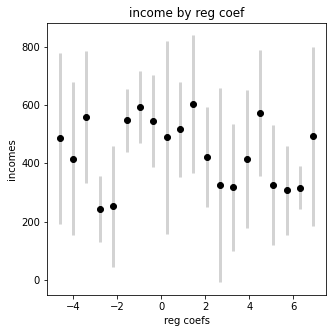

In [420]:
fig = plt.figure(figsize = (5, 5))
plt.errorbar(C_coefs, estimated_incomes, yerr = errors, fmt = 'o', color = 'black', ecolor = 'lightgray', elinewidth = 3)
plt.title('income by reg coef')
plt.xlabel('reg coefs')
plt.ylabel('incomes');

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Не-а. Никакой закономерности не вижу. Каждый раз коэф новый. Иногда эффективным оказывается наибольший коэффициент регуляризации, но всё-таки чаще выигрывает коэф поменьше. Всё, что из этого можно вывести - наша модель любит регуляризацию послабее, т.е. она не склонна переобучаться и предпочитает оставлять за собой свободу подстраивания под данные, это либо потому, что мы пользуемся логистической регрессией, которая в принципе не склонна переобучаться, либо потому, что наши данные более-менее одинаково распределены, т.е. нет такого, что обучающая выборка больше из одного распределения, а тестовая - из другого. И та, и та очень похоже распределены, как бы общую выборку на них не разбивать (разнородность разбиений гарантируется шаффлом). Т.е. мы имеем дело с очень одинаково распределёнными данными, т.е. по ним можно строить хорошие (устойчивые) модели предсказания. Либо это всё бред и низкая переобученность исходит лишь от свойств логистической регрессии.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__

Вообще лучше всего быть и здоровым, и богатым. Но если нужно выбирать, то считаю наиболее важным recall. Ну типа, мы за удачный звонок получаем в 10 раз больше (либо аж до 20), чем тратим на 10 неудачных. Это очень крутое соотношение. Т.е. мы можем позволить себе позвонить очень многим отказникам, и лишь один согласившийся оплатит нам с плюсом ну около 8-9 отказных звонков. Смысл тогда оптимизировать precision? Оптимизируя precision, мы будем уменьшать число отказных звонков, т.е. мы будем сокращать издержки, потраченные впустую. Но это такие копейки. Мы будем на 3-х удачно выкинутых звонках экономить всего 3 Марио-монетки (или в чём там счёт идет). Мне кажется, это слабый эффект в сравнении с потенциальным выигрышем от покрытия всех согласных. 



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [473]:
pipeline = Pipeline([
    ('column_trans', column_transformer),
    ('classifier', LogisticRegression(max_iter = 100000, C = best_C))
])
thresh_incomes = []
thresh_errors = []
for threshold in np.arange(0, 1, 0.05): # у меня не супер-компьютер, я могу позволить себе лишь столько вот порогов
    def threshold_income(y_test, y_test_pred):
        y_test_pred = (y_test_pred >= threshold)
        return sample_income_random(y_test, y_test_pred)
    threshold_income_score = make_scorer(threshold_income, greater_is_better = True, needs_proba = True)
    scores = cross_val_score(pipeline, X_train_val, y_train_val, cv = strati_shuffle, scoring = threshold_income_score)
    thresh_incomes.append(scores.mean())
    thresh_errors.append(scores.std())

In [475]:
thresh_incomes

[170.52078789798716,
 985.2776689210347,
 1060.8579212748064,
 1085.2858349010417,
 804.777903462279,
 223.49663638121092,
 1012.7579833053853,
 452.54058925400795,
 591.1389087170622,
 640.8320860329525,
 568.8891174629453,
 139.87987223397636,
 311.6644519177602,
 316.7345559488514,
 214.02895416256607,
 99.42928458015619,
 72.57615359430034,
 26.650375373235203,
 0.054650802386795226,
 0.0]

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

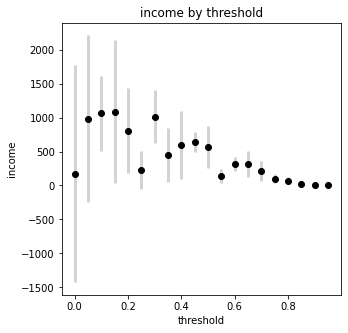

In [476]:
fig = plt.figure(figsize = (5, 5))
plt.errorbar(np.arange(0, 1, 0.05), thresh_incomes, yerr = thresh_errors, fmt = 'o', color = 'black', ecolor = 'lightgray', elinewidth = 3)
plt.title('income by threshold')
plt.xlabel('threshold')
plt.ylabel('income');

In [487]:
income_frame = pd.DataFrame(thresh_incomes).reset_index()
best_threshold_index = int(income_frame.loc[income_frame[0] == income_frame[0].max()]['index'])
space = np.arange(0, 1, 0.05)
best_threshold = space[best_threshold_index]
best_threshold # вот лучший порог

0.15000000000000002

Да, замечаю свою правоту. При нескольких запусках становится очевидно, что самые лучшие пороги смещены к нулевому. Т.е. чем меньше уверенности в положительном ответе нам надо, чтобы совершить звонок, тем больше Марио-монеток мы зарабатываем. Т.е. максимизация recall по сути тождественна максимизации прибыли (наверное поэтому все банки и прочие мошенники всегда звонят с предложением депозита всем подряд, даже одноруким бездомным бабушкам). Я объяснил, почему это так, в своей гипотезе в начале.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [499]:
def thresh_precision(y_test, y_test_pred):
    y_test_pred = (y_test_pred >= best_threshold)
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    return precision.mean()
thresh_precision_score = make_scorer(thresh_precision, greater_is_better = True, needs_proba = True)

def thresh_recall(y_test, y_test_pred):
    y_test_pred = (y_test_pred >= best_threshold)
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    return recall.mean()
thresh_recall_score = make_scorer(thresh_recall, greater_is_better = True, needs_proba = True)

In [500]:
scores_precision = cross_val_score(pipeline, X_train_val, y_train_val, cv = strati_shuffle, scoring = thresh_precision_score)
scores_precision

array([0.49838283, 0.49037683, 0.49663071, 0.49999743, 0.49934769])

In [501]:
scores_precision.mean() # среднее

0.4969470994720503

In [502]:
scores_precision.std() # отклонение

0.003475547955248348

In [503]:
scores_recall = cross_val_score(pipeline, X_train_val, y_train_val, cv = strati_shuffle, scoring = thresh_recall_score)
scores_recall

array([0.53453453, 0.52615845, 0.53512706, 0.52316891, 0.54409567])

In [504]:
scores_recall.mean() # среднее

0.5326169218545901

In [506]:
scores_recall.std() # отклонение

0.007385342570044956

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [507]:
def thresh_recall_count(y_test, y_test_pred, threshold):
    y_test_pred = (y_test_pred >= threshold)
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    return recall.mean()

In [533]:
pipeline.fit(X_train_base, y_train_base)
y_test_pred = pipeline.predict_proba(X_test)[:, 1]

In [534]:
recall_values = []
for threshold in np.arange(0, 1, 0.05):
    recall_value = thresh_recall_count(y_test, y_test_pred, threshold)
    recall_values.append(recall_value)

In [535]:
recall_list = pd.DataFrame(recall_values).reset_index()
index_list = recall_list[recall_list[0] >= 0.5]['index']
chosen = space[index_list]
chosen

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.95])

In [536]:
answers = []
for i in chosen:
    y_test_pred_b = (y_test_pred >= i)
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred_b)
    answers.append(auc(recall, precision))
answers

[0.5563243505705269,
 0.5138997456683776,
 0.4966490039976361,
 0.5120915314695413,
 0.5137225574486525,
 0.5563243505705269]

Ответы готовы!

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__

Итальянскую пасту из твёрдых сортов пшеницы с соусом наполетана от бариллы и французской горчицей.